# ECG Train Model V2
- Base alemã - Lead I (SR/AFIB)
- 100 points & New HB individual normalization

## Import Libraries and setup

In [1]:
import math
import numpy as np
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy

import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (10,5)

## Main Functions

In [2]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [3]:
def correct_rpeaks(signal, rpeaks=None, sampling_rate=100, tol=0.05):
    """Correct R-peak locations to the maximum within a tolerance.
    Parameters
    ----------
    signal : array
        ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    tol : int, float, optional
        Correction tolerance (seconds).
    Returns
    -------
    rpeaks : array
        Cerrected R-peak location indices.
    Notes
    -----
    * The tolerance is defined as the time interval :math:`[R-tol, R+tol[`.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peaks.")

    tol = int(tol * sampling_rate)
    length = len(signal)

    newR = []
    for r in rpeaks:
        a = r - tol
        if a < 0:
            continue
        b = r + tol
        if b > length:
            break
        newR.append(a + np.argmax(signal[a:b]))

    newR = sorted(list(set(newR)))
    newR = np.array(newR, dtype='int')

    return newR

In [4]:
def _extract_heartbeats(signal=None, rpeaks=None, before=400, after=600):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    before : int, optional
        Number of samples to include before the R peak.
    after : int, optional
        Number of samples to include after the R peak.
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR

In [5]:
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.4, after=0.6):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    before : float, optional
        Window size to include before the R peak (seconds).
    after : int, optional
        Window size to include after the R peak (seconds).
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return templates, newR

In [6]:
def get_complete_Heartbit(sample, sampling_rate=100,plot=True):
    filtered_sample = filter_data(sample,sampling_rate)
    data = filtered_sample.T
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    rpeaks = correct_rpeaks(signal=data,rpeaks=peaks, sampling_rate=100,tol=0.05)
    templates, rpeaks = extract_heartbeats(signal=data,rpeaks=rpeaks,sampling_rate=100,before=0.4,after=0.6)
    if plot:
        ts_tmpl = np.linspace(-0.4, 0.6, templates.shape[1], endpoint=False)
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 2)
        ax4 = fig.add_subplot(gs[1:5, 1])
        plt.plot(ts_tmpl, templates.T, 'm', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.set_title('Templates')
        ax4.grid()
    #return templates, rpeaks
    return templates

In [7]:
def get_heart_beat(data):
    templates = []
    templates_aux = []
    for i in range(len(data)-1): 
        templates_aux = get_complete_Heartbit(data[i], 100,False)
        k = len(templates);
        for j in range(len(templates_aux)-1):
            templates.append(templates_aux[j])
    return np.array(templates)

In [8]:
# summarize history for loss
def summarize_loss(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [9]:
def plot_conf_matrix(y_test, y_pred):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test,y_pred), cmap='Blues', annot=True, fmt='g');
    plt.title('Confusion Matrix')
    plt.xlabel("Predictions")
    plt.ylabel("Real values")
    plt.show()

## Import dataset

In [10]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
del df["Unnamed: 0"]
df.shape

(21837, 1006)

In [11]:
df.head(2)

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,-0.117,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
1,2,19.0,0,NaN,70.0,OTHER,0.004,-0.020,-0.053,-0.056,...,-0.035,-0.045,0.004,0.044,0.507,0.554,0.316,0.121,-0.326,-0.348


In [12]:
df.rhythm_diag.value_counts()

SR       16782
OTHER     3541
AFIB      1514
Name: rhythm_diag, dtype: int64

## Prepare data and split SR/AFIB

In [13]:
df = df.loc[df.rhythm_diag != 'OTHER']

In [14]:
df.rhythm_diag.value_counts()

SR      16782
AFIB     1514
Name: rhythm_diag, dtype: int64

In [15]:
df['rhythm_diag'] = df['rhythm_diag'].map(dict(AFIB=1, SR=0))

In [16]:
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [17]:
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)
df=pd.concat([df_minority,maj_class])

In [18]:
df.rhythm_diag.value_counts()

0    1514
1    1514
Name: rhythm_diag, dtype: int64

In [19]:
df_sr = df[df.rhythm_diag == 0]
df_sr = df_sr.drop(['ecg_id', 'age', 'sex', 'height',
                    'weight', 'rhythm_diag'], axis=1)
df_sr.reset_index(drop= True ,inplace=True)
df_sr.shape

(1514, 1000)

In [20]:
df_afib = df[df.rhythm_diag == 1]
df_afib = df_afib.drop(
    ['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1)
df_afib.reset_index(drop=True, inplace=True)
df_afib.shape

(1514, 1000)

In [21]:
X_sr = df_sr.values
X_afib = df_afib.values

In [22]:
X_sr[0].shape

(1000,)

## Get individuals HeartBeats

In [23]:
X_sr = get_heart_beat(X_sr)
X_sr.shape

(14678, 100)

In [24]:
y_sr = np.zeros(len(X_sr))
y_sr.shape

(14678,)

In [25]:
X_afib = get_heart_beat(X_afib)
X_afib.shape

(18190, 100)

In [26]:
y_afib = np.ones(len(X_afib))
y_afib.shape

(18190,)

In [27]:
from numpy import savetxt

for i in range(len(X_sr)):
    savetxt('../data/heart_beat_out_data/sr/sr_' +
            str(i)+'.csv', X_sr[i], delimiter=',')
    savetxt('../data/heart_beat_out_data/afib/afib_' +
            str(i)+'.csv', X_afib[i], delimiter=',')

In [27]:
X = np.concatenate((X_sr, X_afib), axis=0)
X.shape

(32868, 100)

In [28]:
y = np.concatenate((y_sr, y_afib), axis=0)
y.shape

(32868,)

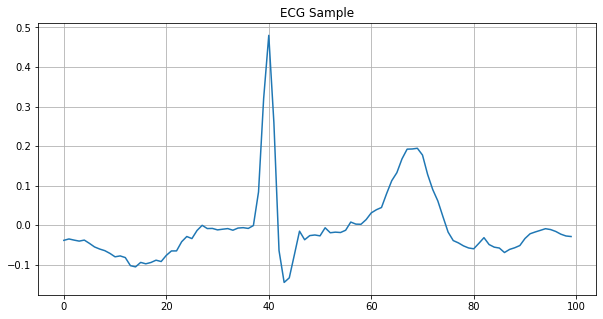

In [29]:
plt.plot(X[0])
plt.title("ECG Sample")
plt.grid()
plt.show()

In [30]:
#saving data
from numpy import save
save('X_100.npy', X)
save('y_100.npy', y)

## Normalize and Split data 

In [12]:
# Getting data

Xt = load('X_100.npy')
yt = load('y_100.npy')

In [13]:
Xt_full = []
for i in range(len(Xt)):
    norm = ((Xt[i] - Xt[i].min())/(Xt[i].max() - Xt[i].min()))
    Xt_full.append(norm)

Xt_full = np.array(Xt_full)
Xt_full.shape

(32868, 100)

In [14]:
yt.shape

(32868,)

In [15]:
print (Xt_full.min(), Xt_full.max())

0.0 1.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(Xt_full,yt,
                                                    test_size=0.20,
                                                    random_state=21)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26294, 100), (6574, 100), (26294,), (6574,))

In [18]:
print (X_train.min(), X_train.max())
print (X_test.min(), X_test.max())

0.0 1.0
0.0 1.0


# Model CNN - 1D
Based on: [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

<img src="../models/cnn_v1.h5.png">

In [19]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print(X_train.shape, X_test.shape)

(26294, 100, 1) (6574, 100, 1)


In [20]:
samples, features, depht = X_train.shape
print(samples, features, depht)

26294 100 1


In [19]:
def group_layer(model):
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [41]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model=group_layer(model)
model=group_layer(model)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 32)           192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 32)            5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 48, 32)            5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 32)            5

In [42]:
lr = 0.0005

In [43]:
opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [44]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [45]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 13s 13ms/step - loss: 0.3249 - accuracy: 0.8602 - val_loss: 0.2532 - val_accuracy: 0.9097
Epoch 2/100
658/658 [==============================] - 9s 13ms/step - loss: 0.2263 - accuracy: 0.9166 - val_loss: 0.2478 - val_accuracy: 0.9137
Epoch 3/100
658/658 [==============================] - 10s 16ms/step - loss: 0.2133 - accuracy: 0.9221 - val_loss: 0.2015 - val_accuracy: 0.9283
Epoch 4/100
658/658 [==============================] - 10s 15ms/step - loss: 0.2010 - accuracy: 0.9275 - val_loss: 0.2028 - val_accuracy: 0.9243
Epoch 5/100
658/658 [==============================] - 9s 14ms/step - loss: 0.1925 - accuracy: 0.9287 - val_loss: 0.2200 - val_accuracy: 0.9258
Epoch 6/100
658/658 [==============================] - 9s 13ms/step - loss: 0.1860 - accuracy: 0.9313 - val_loss: 0.1915 - val_accuracy: 0.9315
Epoch 7/100
658/658 [==============================] - 9s 13ms/step - loss: 0.1828 - accuracy: 0.9317 - val_loss: 0.2020 - val_accura

Model Accuraccy:  0.94


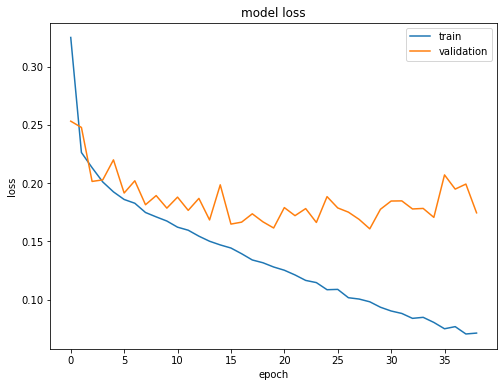

In [46]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.93      0.94      0.93      2958
        AFIB       0.95      0.94      0.95      3616

    accuracy                           0.94      6574
   macro avg       0.94      0.94      0.94      6574
weighted avg       0.94      0.94      0.94      6574



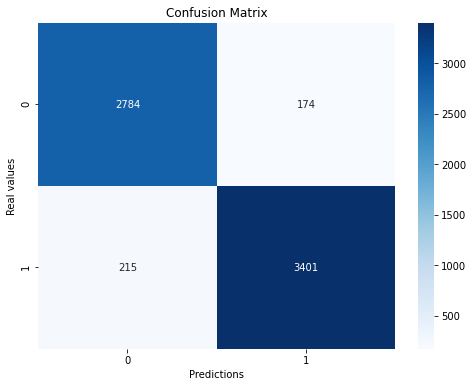

In [47]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [50]:
model.save('../models/cnn_1d_v100.h5')
model.save('../models/cnn_1d_v100')

INFO:tensorflow:Assets written to: ../models/cnn_1d_v100\assets


# Converting model to TF-Lite and TF-Micro

In [31]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [52]:
# Convert TF model to a tflite model
model_cnn_v0 = load_model('../models/cnn_1d_v100')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/cnn_v0.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmppsp8fio3\assets


52704

In [53]:
c_model_name = '../models/cnn_v0'

In [54]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

In [49]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.5))
model=group_layer(model)
model.add(Dropout(0.5))
model=group_layer(model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 100, 32)           192       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 100, 32)           5152      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 48, 32)            5152      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 48, 32)            5152      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 22, 32)           

In [50]:
lr = 0.0005
opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [51]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [52]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 11s 15ms/step - loss: 0.6139 - accuracy: 0.6617 - val_loss: 0.4490 - val_accuracy: 0.8292
Epoch 2/100
658/658 [==============================] - 9s 14ms/step - loss: 0.4144 - accuracy: 0.8240 - val_loss: 0.2685 - val_accuracy: 0.9049
Epoch 3/100
658/658 [==============================] - 10s 15ms/step - loss: 0.3184 - accuracy: 0.8763 - val_loss: 0.2531 - val_accuracy: 0.9146
Epoch 4/100
658/658 [==============================] - 9s 14ms/step - loss: 0.2885 - accuracy: 0.8908 - val_loss: 0.2383 - val_accuracy: 0.9165
Epoch 5/100
658/658 [==============================] - 10s 15ms/step - loss: 0.2767 - accuracy: 0.8977 - val_loss: 0.2299 - val_accuracy: 0.9213
Epoch 6/100
658/658 [==============================] - 10s 15ms/step - loss: 0.2688 - accuracy: 0.9011 - val_loss: 0.2540 - val_accuracy: 0.9177
Epoch 7/100
658/658 [==============================] - 10s 15ms/step - loss: 0.2644 - accuracy: 0.9003 - val_loss: 0.2462 - val_accu

Model Accuraccy:  0.93


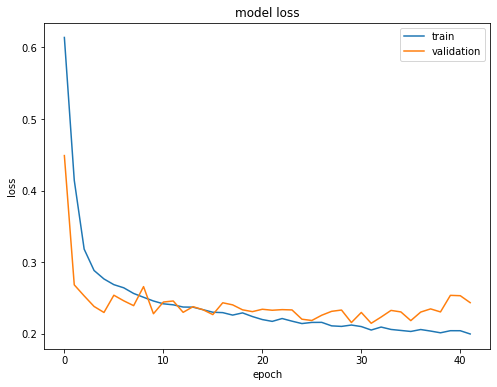

In [53]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

In [54]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 100, 32)           192       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 100, 32)           5152      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 48, 32)            5152      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 48, 32)            5152      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 22, 32)           

In [55]:
lr = 0.0005
opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [56]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [57]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 11s 15ms/step - loss: 0.4239 - accuracy: 0.7894 - val_loss: 0.2595 - val_accuracy: 0.9082
Epoch 2/100
658/658 [==============================] - 9s 14ms/step - loss: 0.2579 - accuracy: 0.9033 - val_loss: 0.2306 - val_accuracy: 0.9135
Epoch 3/100
658/658 [==============================] - 9s 14ms/step - loss: 0.2378 - accuracy: 0.9126 - val_loss: 0.2169 - val_accuracy: 0.9184
Epoch 4/100
658/658 [==============================] - 9s 14ms/step - loss: 0.2268 - accuracy: 0.9147 - val_loss: 0.2036 - val_accuracy: 0.9255
Epoch 5/100
658/658 [==============================] - 10s 15ms/step - loss: 0.2169 - accuracy: 0.9201 - val_loss: 0.1965 - val_accuracy: 0.9291
Epoch 6/100
658/658 [==============================] - 11s 16ms/step - loss: 0.2129 - accuracy: 0.9211 - val_loss: 0.1964 - val_accuracy: 0.9327
Epoch 7/100
658/658 [==============================] - 10s 15ms/step - loss: 0.2065 - accuracy: 0.9241 - val_loss: 0.1888 - val_accur

Model Accuraccy:  0.95


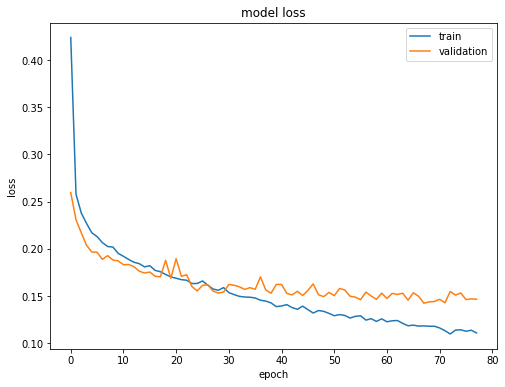

In [58]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

In [59]:
model.save('../models/cnn_1d_v100_drop0_2.h5')
model.save('../models/cnn_1d_v100_drop0_2')

INFO:tensorflow:Assets written to: ../models/cnn_1d_v100_drop0_2\assets


In [61]:
# Convert TF model to a tflite model
model_cnn_v0_drop0_2 = load_model('../models/cnn_1d_v100_drop0_2')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0_drop0_2)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/cnn_v0_drop0_2.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmp4i5g2weo\assets


53264

In [64]:
c_model_name = '../models/cnn_v0_drop0_2'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

## Second try of optimization

In [65]:
# Convert TF model to a tflite model
model_cnn_v0_drop0_3 = load_model('../models/cnn_1d_v100_drop0_2')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0_drop0_3)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open("../models/cnn_v0_drop0_3.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpcbq_vlyh\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpcbq_vlyh\assets


53264

In [66]:
c_model_name = '../models/cnn_v0_drop0_3'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

It got the same performance in terms of memory costs

## Third try of optimization

In [69]:
X_train[1].shape

(100, 1)

In [73]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

In [76]:
representative_dataset = tf.data.Dataset.from_tensor_slices(X_train.astype('float32'))
representative_dataset = representative_dataset.shuffle(buffer_size=10000).batch(1)

model_cnn_v0_drop0_4 = load_model('../models/cnn_1d_v100_drop0_2')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0_drop0_4)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i, samples in enumerate(representative_dataset.take(1)):
        yield [samples]
        
converter.representative_dataset = representative_dataset_gen
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmprbu_s8_7\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmprbu_s8_7\assets


In [78]:
open("../models/cnn_v0_drop0_5.tflite","wb").write(tflite_model_quant)
c_model_name = '../models/cnn_v0_drop0_5'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

It got the same performance in terms of memory costs

## Fourth try of optimization

In [83]:
model_cnn_v0_drop0_6 = load_model('../models/cnn_1d_v100_drop0_2')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0_drop0_6)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmph5818_jn\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmph5818_jn\assets


In [81]:
open("../models/cnn_v0_drop0_6.tflite","wb").write(tflite_quant_model)
c_model_name = '../models/cnn_v0_drop0_6'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

## Fifth try of optimization

In [84]:
model_cnn_v0_drop0_7 = load_model('../models/cnn_1d_v100_drop0_2')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0_drop0_7)
converter.optimizations = [tf.lite.Optimize.DEFAULT]        
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model_quant_8bits = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpjdt70_e3\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpjdt70_e3\assets


In [85]:
open("../models/cnn_v0_drop0_7.tflite","wb").write(tflite_model_quant_8bits)
c_model_name = '../models/cnn_v0_drop0_7'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

## Model with L1 regularization 

In [11]:
from keras.regularizers import l1,l2

In [20]:
def group_layer(model):
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               kernel_regularizer=l1(0.01),
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(32,
               kernel_size=5,
               strides=1,
               kernel_regularizer=l1(0.01),
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [21]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu',kernel_regularizer=l1(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_regularizer=l1(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 100, 32)           192       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 32)           5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 48, 32)            5152      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 48, 32)            5152      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 22, 32)           

In [22]:
lr = 0.0005
opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [23]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [24]:
EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 12s 15ms/step - loss: 4.5581 - accuracy: 0.5547 - val_loss: 0.7104 - val_accuracy: 0.5524
Epoch 2/100
658/658 [==============================] - 11s 17ms/step - loss: 0.7099 - accuracy: 0.5547 - val_loss: 0.7105 - val_accuracy: 0.5524
Epoch 3/100
658/658 [==============================] - 10s 16ms/step - loss: 0.7100 - accuracy: 0.5547 - val_loss: 0.7103 - val_accuracy: 0.5524
Epoch 4/100
658/658 [==============================] - 10s 15ms/step - loss: 0.7099 - accuracy: 0.5547 - val_loss: 0.7105 - val_accuracy: 0.5524
Epoch 5/100
658/658 [==============================] - 10s 15ms/step - loss: 0.7100 - accuracy: 0.5547 - val_loss: 0.7104 - val_accuracy: 0.5524
Epoch 6/100
658/658 [==============================] - 9s 14ms/step - loss: 0.7099 - accuracy: 0.5547 - val_loss: 0.7104 - val_accuracy: 0.5524
Epoch 7/100
658/658 [==============================] - 10s 15ms/step - loss: 0.7099 - accuracy: 0.5547 - val_loss: 0.7103 - val_acc

Model Accuraccy:  0.55


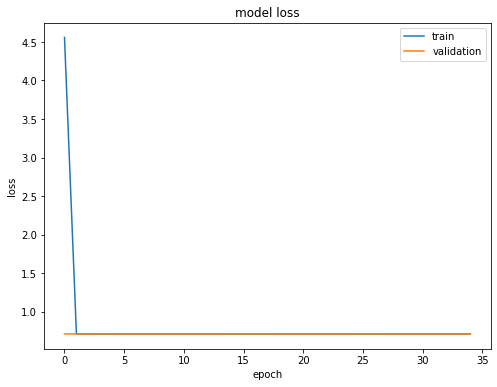

In [27]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)

In [28]:
model.save('../models/cnn_1d_v100_l1.h5')
model.save('../models/cnn_1d_v100_l1')

INFO:tensorflow:Assets written to: ../models/cnn_1d_v100_l1\assets


In [29]:
# Convert TF model to a tflite model
model_cnn_v0_l1 = load_model('../models/cnn_1d_v100_l1')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v0_l1)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/cnn_v0_l1.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmp43ay9w5j\assets


53120

In [32]:
c_model_name = '../models/cnn_v0_l1'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

### Simplifying the model to reduce the memory usage 

In [25]:
def group_layer(model):
    model.add(
        Conv1D(16,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(8,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [30]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 100, 16)           96        
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 100, 8)            648       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 48, 16)            656       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 48, 8)             648       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 22, 8)            

In [27]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [31]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 7s 9ms/step - loss: 0.5606 - accuracy: 0.6892 - val_loss: 0.5365 - val_accuracy: 0.7041
Epoch 2/100
658/658 [==============================] - 6s 9ms/step - loss: 0.4651 - accuracy: 0.7739 - val_loss: 0.3369 - val_accuracy: 0.8737
Epoch 3/100
658/658 [==============================] - 6s 9ms/step - loss: 0.3669 - accuracy: 0.8463 - val_loss: 0.3377 - val_accuracy: 0.8794
Epoch 4/100
658/658 [==============================] - 6s 9ms/step - loss: 0.3303 - accuracy: 0.8650 - val_loss: 0.2831 - val_accuracy: 0.8891
Epoch 5/100
658/658 [==============================] - 6s 9ms/step - loss: 0.3151 - accuracy: 0.8723 - val_loss: 0.3112 - val_accuracy: 0.8783
Epoch 6/100
658/658 [==============================] - 6s 9ms/step - loss: 0.2902 - accuracy: 0.8853 - val_loss: 0.3400 - val_accuracy: 0.8488
Epoch 7/100
658/658 [==============================] - 6s 9ms/step - loss: 0.2842 - accuracy: 0.8881 - val_loss: 0.2846 - val_accuracy: 0.8945

Model Accuraccy:  0.9


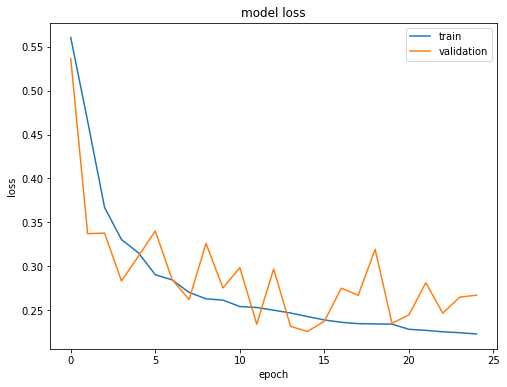

In [32]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.98      0.79      0.88      2958
        AFIB       0.85      0.98      0.91      3616

    accuracy                           0.90      6574
   macro avg       0.91      0.89      0.90      6574
weighted avg       0.91      0.90      0.90      6574



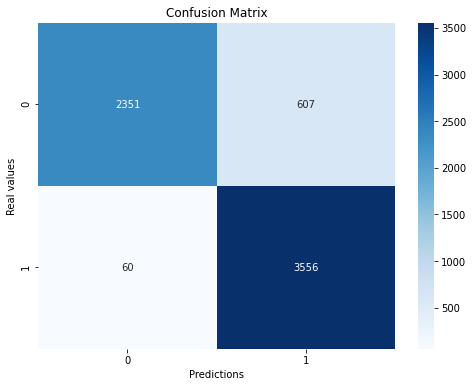

In [33]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [34]:
model.save('../models/cnn_1d_v1_ecg.h5')
model.save('../models/cnn_1d_v1_ecg')
# Convert TF model to a tflite model
model_cnn_v1_ecg = load_model('../models/cnn_1d_v1_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v1_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v1_ecg\assets
INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpitg60an7\assets


38192

In [36]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [37]:
c_model_name = '../models/model_cnn_v1_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 204KB

In [38]:
def group_layer(model):
    model.add(
        Conv1D(8,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(8,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [39]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 100, 8)            48        
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 100, 8)            328       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 48, 8)             328       
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 48, 8)             328       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 22, 8)            

In [40]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 50

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
658/658 [==============================] - 7s 8ms/step - loss: 0.5866 - accuracy: 0.6450 - val_loss: 0.5347 - val_accuracy: 0.6967
Epoch 2/50
658/658 [==============================] - 5s 7ms/step - loss: 0.5105 - accuracy: 0.7330 - val_loss: 0.4509 - val_accuracy: 0.7943
Epoch 3/50
658/658 [==============================] - 5s 8ms/step - loss: 0.4041 - accuracy: 0.8193 - val_loss: 0.3041 - val_accuracy: 0.8772
Epoch 4/50
658/658 [==============================] - 5s 8ms/step - loss: 0.3312 - accuracy: 0.8619 - val_loss: 0.2683 - val_accuracy: 0.8947
Epoch 5/50
658/658 [==============================] - 5s 8ms/step - loss: 0.3079 - accuracy: 0.8738 - val_loss: 0.2706 - val_accuracy: 0.9002
Epoch 6/50
658/658 [==============================] - 5s 8ms/step - loss: 0.2935 - accuracy: 0.8815 - val_loss: 0.2669 - val_accuracy: 0.8956
Epoch 7/50
658/658 [==============================] - 5s 8ms/step - loss: 0.2850 - accuracy: 0.8879 - val_loss: 0.2481 - val_accuracy: 0.9034
Epoch 

Model Accuraccy:  0.93


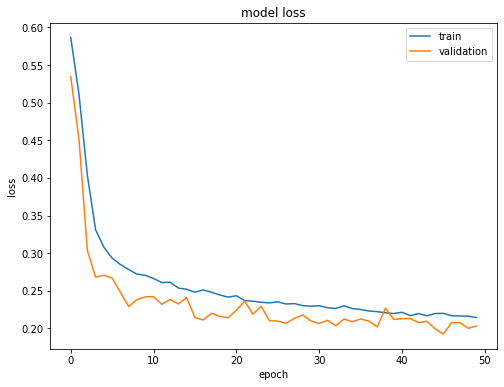

In [41]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.93      0.90      0.92      2958
        AFIB       0.92      0.95      0.93      3616

    accuracy                           0.93      6574
   macro avg       0.93      0.92      0.92      6574
weighted avg       0.93      0.93      0.93      6574



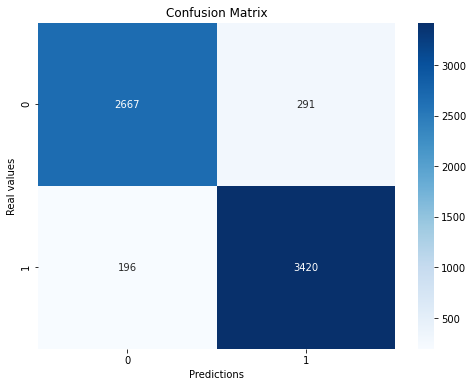

In [42]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [43]:
model.save('../models/cnn_1d_v2_ecg.h5')
model.save('../models/cnn_1d_v2_ecg')
# Convert TF model to a tflite model
model_cnn_v2_ecg = load_model('../models/cnn_1d_v2_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v2_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v2_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v2_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v2_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpquuscyww\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpquuscyww\assets


29008

In [44]:
c_model_name = '../models/model_cnn_v2_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 178KB

In [51]:
def group_layer(model):
    model.add(
        Conv1D(8,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(8,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [52]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 100, 8)            48        
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 100, 8)            328       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 48, 8)             328       
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 48, 8)             328       
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 22, 8)           

In [53]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 50

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
658/658 [==============================] - 7s 8ms/step - loss: 0.5774 - accuracy: 0.6635 - val_loss: 0.4787 - val_accuracy: 0.7693
Epoch 2/50
658/658 [==============================] - 5s 8ms/step - loss: 0.4750 - accuracy: 0.7661 - val_loss: 0.3196 - val_accuracy: 0.8840
Epoch 3/50
658/658 [==============================] - 5s 8ms/step - loss: 0.3387 - accuracy: 0.8638 - val_loss: 0.2509 - val_accuracy: 0.9104
Epoch 4/50
658/658 [==============================] - 5s 8ms/step - loss: 0.3014 - accuracy: 0.8827 - val_loss: 0.2326 - val_accuracy: 0.9129
Epoch 5/50
658/658 [==============================] - 5s 8ms/step - loss: 0.2855 - accuracy: 0.8918 - val_loss: 0.2322 - val_accuracy: 0.9156
Epoch 6/50
658/658 [==============================] - 5s 8ms/step - loss: 0.2772 - accuracy: 0.8942 - val_loss: 0.2290 - val_accuracy: 0.9169
Epoch 7/50
658/658 [==============================] - 5s 8ms/step - loss: 0.2682 - accuracy: 0.8986 - val_loss: 0.2311 - val_accuracy: 0.9160
Epoch 

Model Accuraccy:  0.93


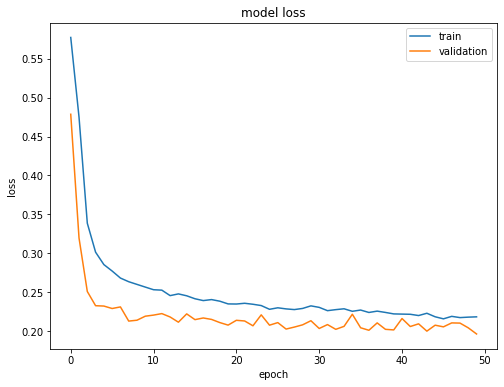

In [54]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.95      0.89      0.92      2958
        AFIB       0.91      0.96      0.94      3616

    accuracy                           0.93      6574
   macro avg       0.93      0.92      0.93      6574
weighted avg       0.93      0.93      0.93      6574



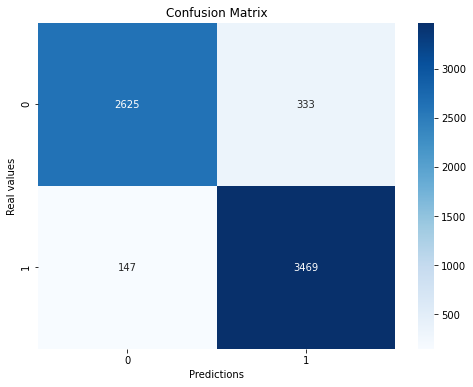

In [55]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [56]:
model.save('../models/cnn_1d_v3_ecg.h5')
model.save('../models/cnn_1d_v3_ecg')
# Convert TF model to a tflite model
model_cnn_v3_ecg = load_model('../models/cnn_1d_v3_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v3_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v3_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v3_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v3_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmp7fjf4g5l\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmp7fjf4g5l\assets


26608

In [57]:
c_model_name = '../models/model_cnn_v3_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 152KB

In [58]:
def group_layer(model):
    model.add(
        Conv1D(4,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(4,
               kernel_size=5,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [59]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, 100, 4)            24        
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 100, 4)            84        
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 48, 4)             0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 48, 4)             0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 48, 4)             84        
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 48, 4)             84        
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 22, 4)           

In [60]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 50

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
658/658 [==============================] - 6s 7ms/step - loss: 0.5715 - accuracy: 0.6774 - val_loss: 0.5297 - val_accuracy: 0.7344
Epoch 2/50
658/658 [==============================] - 4s 6ms/step - loss: 0.5290 - accuracy: 0.7198 - val_loss: 0.5000 - val_accuracy: 0.7425
Epoch 3/50
658/658 [==============================] - 4s 6ms/step - loss: 0.5118 - accuracy: 0.7300 - val_loss: 0.4959 - val_accuracy: 0.7450
Epoch 4/50
658/658 [==============================] - 4s 6ms/step - loss: 0.5009 - accuracy: 0.7465 - val_loss: 0.4933 - val_accuracy: 0.7519
Epoch 5/50
658/658 [==============================] - 4s 6ms/step - loss: 0.4846 - accuracy: 0.7556 - val_loss: 0.4519 - val_accuracy: 0.8032
Epoch 6/50
658/658 [==============================] - 4s 6ms/step - loss: 0.4605 - accuracy: 0.7825 - val_loss: 0.4214 - val_accuracy: 0.8254
Epoch 7/50
658/658 [==============================] - 4s 6ms/step - loss: 0.4336 - accuracy: 0.7987 - val_loss: 0.4541 - val_accuracy: 0.7741
Epoch 

Model Accuraccy:  0.89


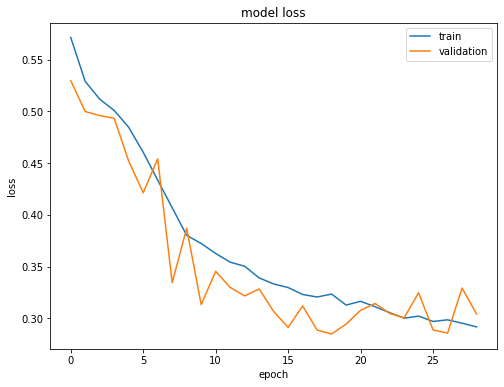

In [61]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.94      0.80      0.87      2958
        AFIB       0.85      0.96      0.90      3616

    accuracy                           0.89      6574
   macro avg       0.90      0.88      0.89      6574
weighted avg       0.89      0.89      0.89      6574



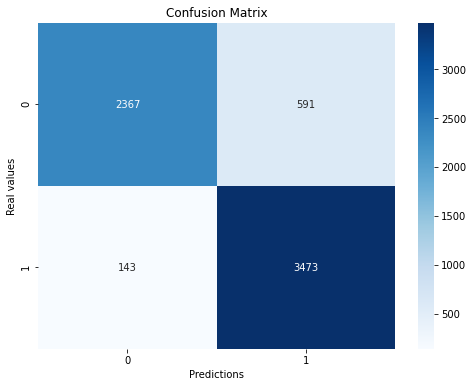

In [62]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [63]:
model.save('../models/cnn_1d_v4_ecg.h5')
model.save('../models/cnn_1d_v4_ecg')
# Convert TF model to a tflite model
model_cnn_v4_ecg = load_model('../models/cnn_1d_v4_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v4_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v4_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v4_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v4_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpt29s15gi\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpt29s15gi\assets


21168

In [64]:
c_model_name = '../models/model_cnn_v4_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 116KB

In [68]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_106 (Conv1D)          (None, 100, 4)            24        
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 100, 4)            84        
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 48, 4)             0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 48, 4)             0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 48, 4)             84        
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 48, 4)             84        
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 22, 4)           

In [69]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 30

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/30
658/658 [==============================] - 6s 7ms/step - loss: 0.5890 - accuracy: 0.6490 - val_loss: 0.5234 - val_accuracy: 0.7292
Epoch 2/30
658/658 [==============================] - 4s 6ms/step - loss: 0.5349 - accuracy: 0.7068 - val_loss: 0.5073 - val_accuracy: 0.7387
Epoch 3/30
658/658 [==============================] - 4s 6ms/step - loss: 0.5151 - accuracy: 0.7317 - val_loss: 0.5126 - val_accuracy: 0.7209
Epoch 4/30
658/658 [==============================] - 4s 6ms/step - loss: 0.5056 - accuracy: 0.7435 - val_loss: 0.6198 - val_accuracy: 0.6271
Epoch 5/30
658/658 [==============================] - 4s 6ms/step - loss: 0.4947 - accuracy: 0.7505 - val_loss: 0.6251 - val_accuracy: 0.6271
Epoch 6/30
658/658 [==============================] - 4s 6ms/step - loss: 0.4866 - accuracy: 0.7596 - val_loss: 0.6046 - val_accuracy: 0.6556
Epoch 7/30
658/658 [==============================] - 4s 6ms/step - loss: 0.4771 - accuracy: 0.7660 - val_loss: 0.6005 - val_accuracy: 0.6298
Epoch 

In [29]:
def group_layer(model):
    model.add(
        Conv1D(8,
               kernel_size=7,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(
        Conv1D(8,
               kernel_size=7,
               strides=1,
               padding='same',
               activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2))
    return model

In [46]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 48, 8)             456       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 48, 8)             456       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 22, 8)            

In [31]:
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=10)

In [47]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 5s 7ms/step - loss: 0.3901 - accuracy: 0.8159 - val_loss: 0.2579 - val_accuracy: 0.9045
Epoch 2/100
658/658 [==============================] - 4s 7ms/step - loss: 0.2650 - accuracy: 0.8994 - val_loss: 0.2361 - val_accuracy: 0.9093
Epoch 3/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2479 - accuracy: 0.9040 - val_loss: 0.2173 - val_accuracy: 0.9161
Epoch 4/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2389 - accuracy: 0.9073 - val_loss: 0.2173 - val_accuracy: 0.9175
Epoch 5/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2301 - accuracy: 0.9138 - val_loss: 0.2232 - val_accuracy: 0.9154
Epoch 6/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2254 - accuracy: 0.9143 - val_loss: 0.2082 - val_accuracy: 0.9243
Epoch 7/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2225 - accuracy: 0.9159 - val_loss: 0.2134 - val_accuracy: 0.9188

Epoch 58/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1663 - accuracy: 0.9394 - val_loss: 0.1721 - val_accuracy: 0.9367
Epoch 59/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1641 - accuracy: 0.9388 - val_loss: 0.1708 - val_accuracy: 0.9369
Epoch 60/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1633 - accuracy: 0.9392 - val_loss: 0.1628 - val_accuracy: 0.9412
Epoch 61/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1663 - accuracy: 0.9394 - val_loss: 0.1656 - val_accuracy: 0.9407
Epoch 62/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1626 - accuracy: 0.9389 - val_loss: 0.1626 - val_accuracy: 0.9392
Epoch 63/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1638 - accuracy: 0.9390 - val_loss: 0.1676 - val_accuracy: 0.9359
Epoch 64/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1669 - accuracy: 0.9392 - val_loss: 0.1776 - val_accuracy:

Model Accuraccy:  0.94


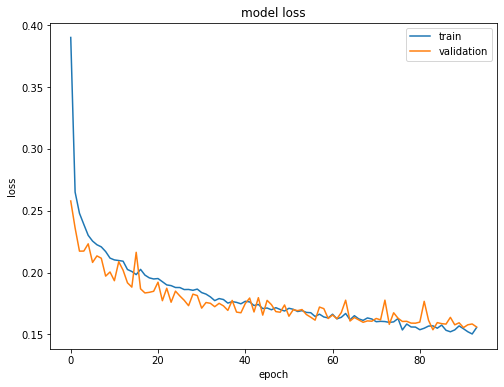

In [48]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.93      0.94      0.93      2958
        AFIB       0.95      0.94      0.95      3616

    accuracy                           0.94      6574
   macro avg       0.94      0.94      0.94      6574
weighted avg       0.94      0.94      0.94      6574



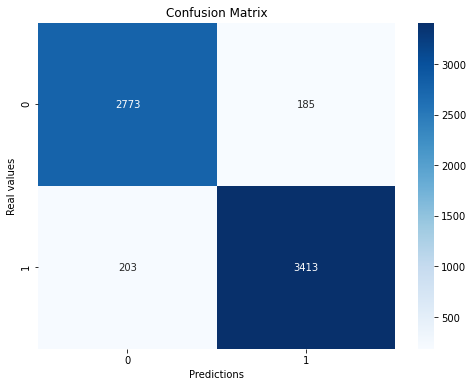

In [49]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [50]:
model.save('../models/cnn_1d_v5_ecg.h5')
model.save('../models/cnn_1d_v5_ecg')
# Convert TF model to a tflite model
model_cnn_v5_ecg = load_model('../models/cnn_1d_v5_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v5_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v5_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v5_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v5_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpbsjeybpu\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpbsjeybpu\assets


25936

In [37]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [51]:
c_model_name = '../models/model_cnn_v5_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 159KB

In [52]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 48, 8)             456       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 48, 8)             456       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 22, 8)            

In [53]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 5s 7ms/step - loss: 0.4351 - accuracy: 0.7885 - val_loss: 0.2616 - val_accuracy: 0.9034
Epoch 2/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2709 - accuracy: 0.8986 - val_loss: 0.2368 - val_accuracy: 0.9091
Epoch 3/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2507 - accuracy: 0.9040 - val_loss: 0.2225 - val_accuracy: 0.9173
Epoch 4/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2458 - accuracy: 0.9085 - val_loss: 0.2152 - val_accuracy: 0.9207
Epoch 5/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2333 - accuracy: 0.9118 - val_loss: 0.2191 - val_accuracy: 0.9201
Epoch 6/100
658/658 [==============================] - 4s 7ms/step - loss: 0.2314 - accuracy: 0.9146 - val_loss: 0.2169 - val_accuracy: 0.9199
Epoch 7/100
658/658 [==============================] - 4s 7ms/step - loss: 0.2259 - accuracy: 0.9157 - val_loss: 0.2043 - val_accuracy: 0.9281

Epoch 58/100
658/658 [==============================] - 5s 7ms/step - loss: 0.1737 - accuracy: 0.9346 - val_loss: 0.1635 - val_accuracy: 0.9390
Epoch 59/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1708 - accuracy: 0.9374 - val_loss: 0.1661 - val_accuracy: 0.9380
Epoch 60/100
658/658 [==============================] - 4s 7ms/step - loss: 0.1703 - accuracy: 0.9389 - val_loss: 0.1646 - val_accuracy: 0.9403
Epoch 61/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1734 - accuracy: 0.9368 - val_loss: 0.1712 - val_accuracy: 0.9376
Epoch 62/100
658/658 [==============================] - 4s 6ms/step - loss: 0.1686 - accuracy: 0.9372 - val_loss: 0.1700 - val_accuracy: 0.9355
Epoch 63/100
658/658 [==============================] - 5s 7ms/step - loss: 0.1703 - accuracy: 0.9361 - val_loss: 0.1576 - val_accuracy: 0.9407
Epoch 64/100
658/658 [==============================] - 5s 7ms/step - loss: 0.1744 - accuracy: 0.9373 - val_loss: 0.1729 - val_accuracy:

Model Accuraccy:  0.94


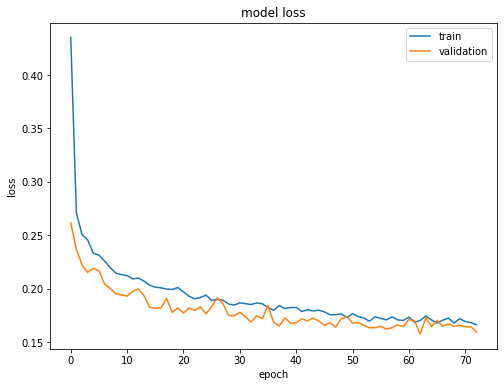

In [58]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.94      0.91      0.93      2958
        AFIB       0.93      0.95      0.94      3616

    accuracy                           0.94      6574
   macro avg       0.94      0.93      0.94      6574
weighted avg       0.94      0.94      0.94      6574



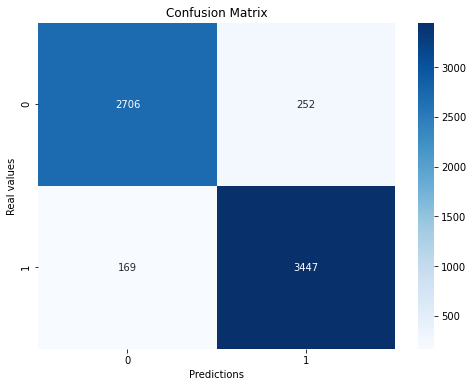

In [59]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [56]:
model.save('../models/cnn_1d_v6_ecg.h5')
model.save('../models/cnn_1d_v6_ecg')
# Convert TF model to a tflite model
model_cnn_v6_ecg = load_model('../models/cnn_1d_v6_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v6_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v6_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v6_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v6_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpa_falkqa\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpa_falkqa\assets


20048

In [57]:
c_model_name = '../models/model_cnn_v6_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 123KB

In [60]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                12320     
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)               

In [61]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 4s 5ms/step - loss: 0.3693 - accuracy: 0.8454 - val_loss: 0.2615 - val_accuracy: 0.9083
Epoch 2/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2683 - accuracy: 0.9015 - val_loss: 0.2295 - val_accuracy: 0.9201
Epoch 3/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2471 - accuracy: 0.9101 - val_loss: 0.2231 - val_accuracy: 0.9217
Epoch 4/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2393 - accuracy: 0.9126 - val_loss: 0.2154 - val_accuracy: 0.9239
Epoch 5/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2277 - accuracy: 0.9155 - val_loss: 0.2102 - val_accuracy: 0.9270
Epoch 6/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2225 - accuracy: 0.9186 - val_loss: 0.2098 - val_accuracy: 0.9255
Epoch 7/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2203 - accuracy: 0.9191 - val_loss: 0.1991 - val_accuracy: 0.9308

Epoch 58/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1507 - accuracy: 0.9453 - val_loss: 0.1620 - val_accuracy: 0.9431
Epoch 59/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1538 - accuracy: 0.9413 - val_loss: 0.1639 - val_accuracy: 0.9420
Epoch 60/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1515 - accuracy: 0.9453 - val_loss: 0.1622 - val_accuracy: 0.9433
Epoch 61/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1508 - accuracy: 0.9420 - val_loss: 0.1664 - val_accuracy: 0.9411
Epoch 62/100
658/658 [==============================] - 3s 5ms/step - loss: 0.1498 - accuracy: 0.9447 - val_loss: 0.1677 - val_accuracy: 0.9430
Epoch 00062: early stopping


Model Accuraccy:  0.94


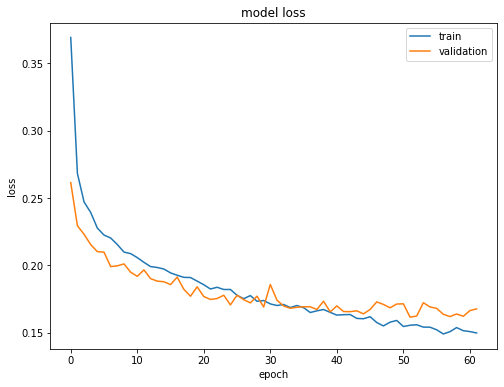

In [62]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.95      0.91      0.93      2958
        AFIB       0.93      0.96      0.94      3616

    accuracy                           0.94      6574
   macro avg       0.94      0.94      0.94      6574
weighted avg       0.94      0.94      0.94      6574



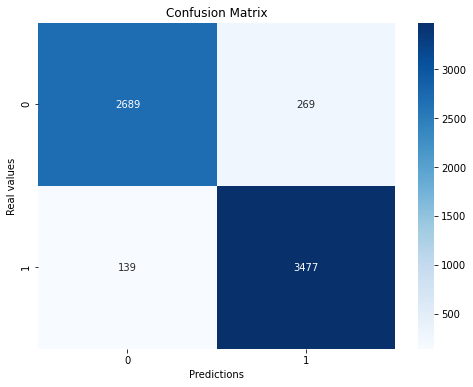

In [63]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [64]:
model.save('../models/cnn_1d_v7_ecg.h5')
model.save('../models/cnn_1d_v7_ecg')
# Convert TF model to a tflite model
model_cnn_v7_ecg = load_model('../models/cnn_1d_v7_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v7_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v7_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v7_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v7_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpp1rj13f1\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpp1rj13f1\assets


19760

In [65]:
c_model_name = '../models/model_cnn_v7_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 121KB

In [66]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                6160      
_________________________________________________________________
dropout_30 (Dropout)         (None, 16)               

In [67]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 4s 5ms/step - loss: 0.4177 - accuracy: 0.8126 - val_loss: 0.2777 - val_accuracy: 0.9053
Epoch 2/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2791 - accuracy: 0.8954 - val_loss: 0.2377 - val_accuracy: 0.9116
Epoch 3/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2543 - accuracy: 0.9053 - val_loss: 0.2281 - val_accuracy: 0.9163
Epoch 4/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2437 - accuracy: 0.9084 - val_loss: 0.2327 - val_accuracy: 0.9173
Epoch 5/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2414 - accuracy: 0.9121 - val_loss: 0.2208 - val_accuracy: 0.9207
Epoch 6/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2351 - accuracy: 0.9134 - val_loss: 0.2153 - val_accuracy: 0.9230
Epoch 7/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2350 - accuracy: 0.9132 - val_loss: 0.2122 - val_accuracy: 0.9237

Epoch 58/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1791 - accuracy: 0.9319 - val_loss: 0.1777 - val_accuracy: 0.9336
Epoch 59/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1816 - accuracy: 0.9339 - val_loss: 0.1746 - val_accuracy: 0.9344
Epoch 60/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1802 - accuracy: 0.9341 - val_loss: 0.1757 - val_accuracy: 0.9367
Epoch 61/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1820 - accuracy: 0.9327 - val_loss: 0.1724 - val_accuracy: 0.9367
Epoch 62/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1804 - accuracy: 0.9340 - val_loss: 0.1727 - val_accuracy: 0.9376
Epoch 63/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1772 - accuracy: 0.9349 - val_loss: 0.1757 - val_accuracy: 0.9353
Epoch 64/100
658/658 [==============================] - 3s 4ms/step - loss: 0.1747 - accuracy: 0.9359 - val_loss: 0.1679 - val_accuracy:

Model Accuraccy:  0.94


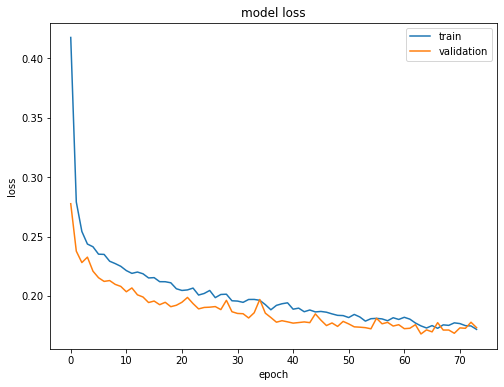

In [68]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.95      0.91      0.93      2958
        AFIB       0.93      0.96      0.94      3616

    accuracy                           0.94      6574
   macro avg       0.94      0.93      0.94      6574
weighted avg       0.94      0.94      0.94      6574



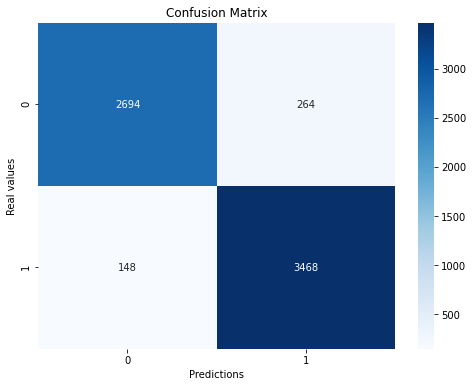

In [69]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [70]:
model.save('../models/cnn_1d_v8_ecg.h5')
model.save('../models/cnn_1d_v8_ecg')
# Convert TF model to a tflite model
model_cnn_v8_ecg = load_model('../models/cnn_1d_v8_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v8_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v8_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v8_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v8_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmprlwwengm\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmprlwwengm\assets


13504

In [71]:
c_model_name = '../models/model_cnn_v8_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 83KB

In [72]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 3080      
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)               

In [73]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 4s 5ms/step - loss: 0.4213 - accuracy: 0.8138 - val_loss: 0.2914 - val_accuracy: 0.9040
Epoch 2/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2940 - accuracy: 0.8929 - val_loss: 0.2554 - val_accuracy: 0.9034
Epoch 3/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2751 - accuracy: 0.8998 - val_loss: 0.2345 - val_accuracy: 0.9144
Epoch 4/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2653 - accuracy: 0.9024 - val_loss: 0.2414 - val_accuracy: 0.9097
Epoch 5/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2652 - accuracy: 0.9050 - val_loss: 0.2270 - val_accuracy: 0.9182
Epoch 6/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2564 - accuracy: 0.9072 - val_loss: 0.2373 - val_accuracy: 0.9169
Epoch 7/100
658/658 [==============================] - 3s 4ms/step - loss: 0.2517 - accuracy: 0.9073 - val_loss: 0.2265 - val_accuracy: 0.9194

Model Accuraccy:  0.93


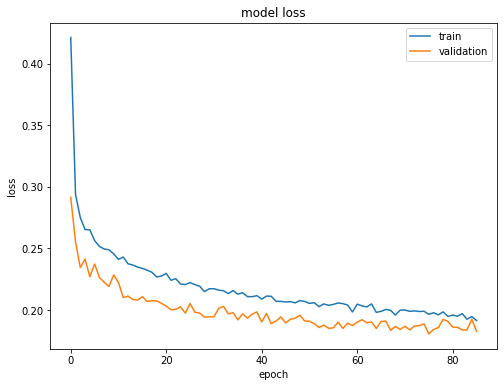

In [74]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.94      0.91      0.92      2958
        AFIB       0.93      0.95      0.94      3616

    accuracy                           0.93      6574
   macro avg       0.93      0.93      0.93      6574
weighted avg       0.93      0.93      0.93      6574



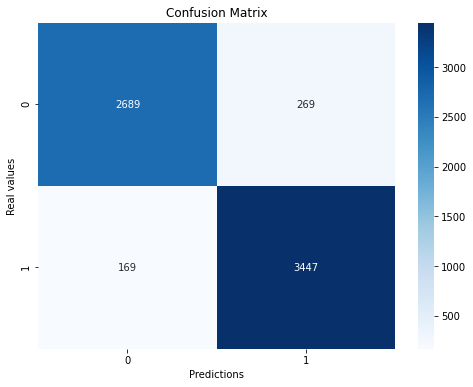

In [75]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [76]:
model.save('../models/cnn_1d_v9_ecg.h5')
model.save('../models/cnn_1d_v9_ecg')
# Convert TF model to a tflite model
model_cnn_v9_ecg = load_model('../models/cnn_1d_v9_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v9_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v9_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v9_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v9_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpao8fsu1t\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpao8fsu1t\assets


10400

In [77]:
c_model_name = '../models/model_cnn_v9_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 64KB

In [78]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 1540      
_________________________________________________________________
dropout_34 (Dropout)         (None, 4)               

In [79]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 5s 6ms/step - loss: 0.4172 - accuracy: 0.8242 - val_loss: 0.2676 - val_accuracy: 0.9057
Epoch 2/100
658/658 [==============================] - 3s 5ms/step - loss: 0.3082 - accuracy: 0.8921 - val_loss: 0.2415 - val_accuracy: 0.9099
Epoch 3/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2855 - accuracy: 0.8995 - val_loss: 0.2420 - val_accuracy: 0.9141
Epoch 4/100
658/658 [==============================] - 4s 6ms/step - loss: 0.2736 - accuracy: 0.9032 - val_loss: 0.2371 - val_accuracy: 0.9131
Epoch 5/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2698 - accuracy: 0.9019 - val_loss: 0.2242 - val_accuracy: 0.9148
Epoch 6/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2648 - accuracy: 0.9043 - val_loss: 0.2259 - val_accuracy: 0.9152
Epoch 7/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2581 - accuracy: 0.9061 - val_loss: 0.2257 - val_accuracy: 0.9186

Model Accuraccy:  0.93


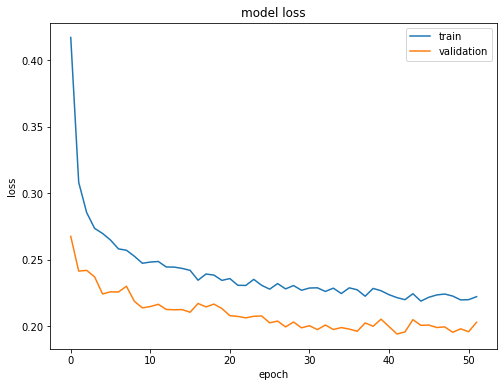

In [80]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.93      0.91      0.92      2958
        AFIB       0.93      0.94      0.94      3616

    accuracy                           0.93      6574
   macro avg       0.93      0.93      0.93      6574
weighted avg       0.93      0.93      0.93      6574



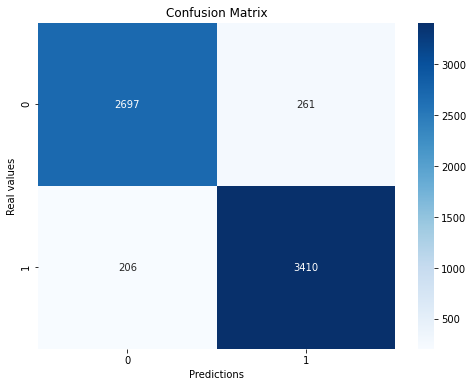

In [81]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [82]:
model.save('../models/cnn_1d_v10_ecg.h5')
model.save('../models/cnn_1d_v10_ecg')
# Convert TF model to a tflite model
model_cnn_v10_ecg = load_model('../models/cnn_1d_v10_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v10_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v10_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v10_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v10_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpp_evpeus\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpp_evpeus\assets


8832

In [83]:
c_model_name = '../models/model_cnn_v10_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 55KB

In [84]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 770       
_________________________________________________________________
dropout_36 (Dropout)         (None, 2)               

In [85]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 4s 6ms/step - loss: 0.5473 - accuracy: 0.7401 - val_loss: 0.4362 - val_accuracy: 0.8827
Epoch 2/100
658/658 [==============================] - 3s 5ms/step - loss: 0.4241 - accuracy: 0.8636 - val_loss: 0.3522 - val_accuracy: 0.9091
Epoch 3/100
658/658 [==============================] - 3s 5ms/step - loss: 0.3757 - accuracy: 0.8755 - val_loss: 0.3129 - val_accuracy: 0.9091
Epoch 4/100
658/658 [==============================] - 3s 5ms/step - loss: 0.3537 - accuracy: 0.8783 - val_loss: 0.2929 - val_accuracy: 0.9104
Epoch 5/100
658/658 [==============================] - 3s 5ms/step - loss: 0.3467 - accuracy: 0.8759 - val_loss: 0.2833 - val_accuracy: 0.9129
Epoch 6/100
658/658 [==============================] - 3s 5ms/step - loss: 0.3362 - accuracy: 0.8813 - val_loss: 0.2789 - val_accuracy: 0.9078
Epoch 7/100
658/658 [==============================] - 3s 5ms/step - loss: 0.3320 - accuracy: 0.8810 - val_loss: 0.2679 - val_accuracy: 0.9158

Epoch 58/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2986 - accuracy: 0.8950 - val_loss: 0.2405 - val_accuracy: 0.9165
Epoch 59/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2963 - accuracy: 0.8958 - val_loss: 0.2373 - val_accuracy: 0.9236
Epoch 60/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2957 - accuracy: 0.8953 - val_loss: 0.2410 - val_accuracy: 0.9192
Epoch 61/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2986 - accuracy: 0.8940 - val_loss: 0.2382 - val_accuracy: 0.9224
Epoch 62/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2897 - accuracy: 0.8991 - val_loss: 0.2387 - val_accuracy: 0.9220
Epoch 63/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2958 - accuracy: 0.8940 - val_loss: 0.2332 - val_accuracy: 0.9230
Epoch 64/100
658/658 [==============================] - 3s 5ms/step - loss: 0.2930 - accuracy: 0.8958 - val_loss: 0.2362 - val_accuracy:

Model Accuraccy:  0.92


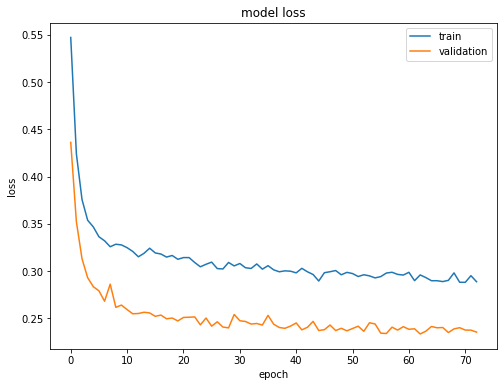

In [86]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.92      0.91      0.91      2958
        AFIB       0.93      0.93      0.93      3616

    accuracy                           0.92      6574
   macro avg       0.92      0.92      0.92      6574
weighted avg       0.92      0.92      0.92      6574



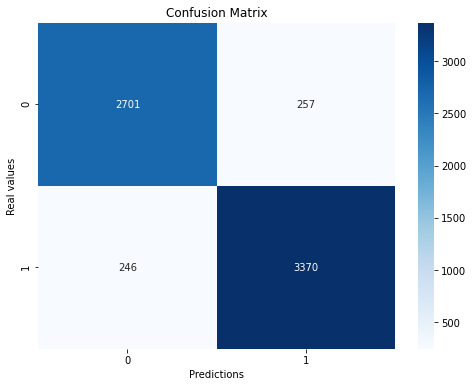

In [87]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [88]:
model.save('../models/cnn_1d_v11_ecg.h5')
model.save('../models/cnn_1d_v11_ecg')
# Convert TF model to a tflite model
model_cnn_v11_ecg = load_model('../models/cnn_1d_v11_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v11_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v11_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v11_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v11_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpmr7jq8_3\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpmr7jq8_3\assets


10320

In [89]:
c_model_name = '../models/model_cnn_v11_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 62KB

In [91]:
model = Sequential()
model.add(Input(shape=(features, depht)))
model=group_layer(model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 100, 8)            64        
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 100, 8)            456       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 48, 8)             0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 48, 8)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 385       
_________________________________________________________________
dropout_40 (Dropout)         (None, 1)               

In [92]:
opt = Adam(beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


EPOCHS = 100

history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/100
658/658 [==============================] - 4s 5ms/step - loss: 0.5913 - accuracy: 0.6673 - val_loss: 0.4815 - val_accuracy: 0.8703
Epoch 2/100
658/658 [==============================] - 3s 5ms/step - loss: 0.4923 - accuracy: 0.7875 - val_loss: 0.3959 - val_accuracy: 0.8979
Epoch 3/100
658/658 [==============================] - 4s 6ms/step - loss: 0.4574 - accuracy: 0.8035 - val_loss: 0.3685 - val_accuracy: 0.9028
Epoch 4/100
658/658 [==============================] - 4s 5ms/step - loss: 0.4439 - accuracy: 0.8067 - val_loss: 0.3527 - val_accuracy: 0.8986
Epoch 5/100
658/658 [==============================] - 3s 5ms/step - loss: 0.4394 - accuracy: 0.8109 - val_loss: 0.3429 - val_accuracy: 0.9023
Epoch 6/100
658/658 [==============================] - 3s 5ms/step - loss: 0.4351 - accuracy: 0.8135 - val_loss: 0.3254 - val_accuracy: 0.9093
Epoch 7/100
658/658 [==============================] - 3s 5ms/step - loss: 0.4382 - accuracy: 0.8124 - val_loss: 0.3331 - val_accuracy: 0.9070

Model Accuraccy:  0.92


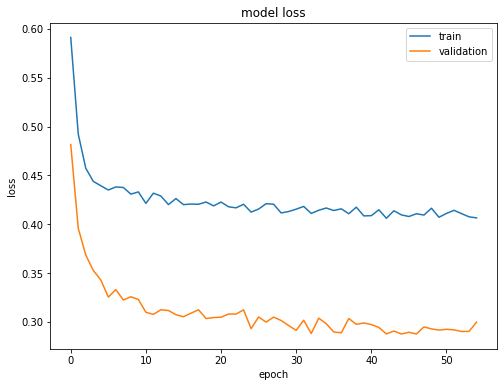

In [93]:
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Model Accuraccy: ", round(model_accuracy, 2))
summarize_loss(history)


		ECG - CNN V1 - MODEL EVALUATION

              precision    recall  f1-score   support

          SR       0.89      0.93      0.91      2958
        AFIB       0.94      0.90      0.92      3616

    accuracy                           0.92      6574
   macro avg       0.91      0.92      0.92      6574
weighted avg       0.92      0.92      0.92      6574



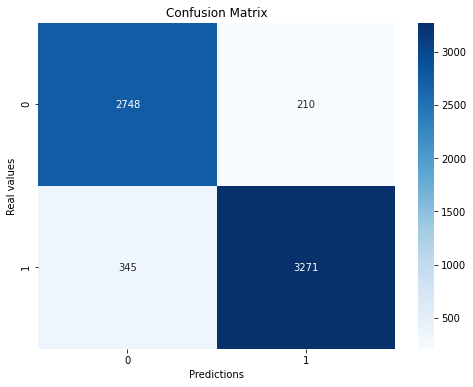

In [94]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5
print('\n\t\tECG - CNN V1 - MODEL EVALUATION\n')
print(classification_report(y_test, y_pred, target_names=['SR', 'AFIB']))
plot_conf_matrix(y_test, y_pred)

In [95]:
model.save('../models/cnn_1d_v12_ecg.h5')
model.save('../models/cnn_1d_v12_ecg')
# Convert TF model to a tflite model
model_cnn_v12_ecg = load_model('../models/cnn_1d_v12_ecg')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v12_ecg)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open("../models/model_cnn_v12_ecg.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: ../models/cnn_1d_v12_ecg\assets


INFO:tensorflow:Assets written to: ../models/cnn_1d_v12_ecg\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpffaj_w7u\assets


INFO:tensorflow:Assets written to: C:\Users\GUILH\AppData\Local\Temp\tmpffaj_w7u\assets


8752

In [96]:
c_model_name = '../models/model_cnn_v12_ecg'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

Consultando o diretório onde se salvou os arquivos otimizados, percebe-se que há um gasto de memória de 54KB

`The model has 36K trainable params and uses 320Kb of memory`